# **Dataset**

In [ ]:
!pip install Kaggle
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification -p data
!unzip ./data/recyclable-and-household-waste-classification.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_1.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_10.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_100.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_101.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_102.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_103.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_104.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_105.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_106.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_107.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_108.png  
  inflating: ./data/images/images/plastic_shopping_bags/default/Image_10

# **Import Library**

In [ ]:
import os
import shutil
import random
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16

In [ ]:
base_path = "data/images/images"

main_folders = [
    "aerosol_cans",
    "aluminum_food_cans",
    "aluminum_soda_cans",
    "cardboard_boxes",
    "cardboard_packaging",
    "clothing",
    "coffee_grounds",
    "disposable_plastic_cutlery",
    "eggshells",
    "food_waste",
    "glass_beverage_bottles",
    "glass_cosmetic_containers",
    "glass_food_jars",
    "magazines",
    "newspaper",
    "office_paper",
    "paper_cups",
    "plastic_cup_lids",
    "plastic_detergent_bottles",
    "plastic_food_containers",
    "plastic_shopping_bags",
    "plastic_soda_bottles",
    "plastic_straws",
    "plastic_trash_bags",
    "plastic_water_bottles",
    "shoes",
    "steel_food_cans",
    "styrofoam_cups",
    "styrofoam_food_containers",
    "tea_bags"
]

for folder in main_folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                for item in os.listdir(subfolder_path):
                    item_path = os.path.join(subfolder_path, item)
                    dest_path = os.path.join(folder_path, os.path.basename(item))

                    if os.path.exists(dest_path):
                        base, ext = os.path.splitext(dest_path)
                        counter = 1
                        new_dest_path = f"{base}_{counter}{ext}"
                        while os.path.exists(new_dest_path):
                            counter += 1
                            new_dest_path = f"{base}_{counter}{ext}"
                        dest_path = new_dest_path

                    shutil.move(item_path, dest_path)
                os.rmdir(subfolder_path)

print("Proses selesai. Semua isi subfolder telah dipindahkan.")

Proses selesai. Semua isi subfolder telah dipindahkan.


In [ ]:
base_path = "data/images/images"
organik_path = os.path.join(base_path, "organik")
anorganik_path = os.path.join(base_path, "anorganik")

os.makedirs(organik_path, exist_ok=True)
os.makedirs(anorganik_path, exist_ok=True)

organik_folders = [
    "coffee_grounds",
    "eggshells",
    "food_waste",
    "tea_bags"
]

anorganik_folders = [
    "aerosol_cans",
    "aluminum_food_cans",
    "aluminum_soda_cans",
    "cardboard_boxes",
    "cardboard_packaging",
    "clothing",
    "disposable_plastic_cutlery",
    "glass_beverage_bottles",
    "glass_cosmetic_containers",
    "glass_food_jars",
    "magazines",
    "newspaper",
    "office_paper",
    "paper_cups",
    "plastic_cup_lids",
    "plastic_detergent_bottles",
    "plastic_food_containers",
    "plastic_shopping_bags",
    "plastic_soda_bottles",
    "plastic_straws",
    "plastic_trash_bags",
    "plastic_water_bottles",
    "shoes",
    "steel_food_cans",
    "styrofoam_cups",
    "styrofoam_food_containers"
]

def move_folder(folder_list, dest_path):
    for folder in folder_list:
        source_path = os.path.join(base_path, folder)
        if os.path.exists(source_path):
            shutil.move(source_path, dest_path)

move_folder(organik_folders, organik_path)
move_folder(anorganik_folders, anorganik_path)

print("Proses pemisahan dataset menjadi organik dan anorganik selesai.")

Proses pemisahan dataset menjadi organik dan anorganik selesai.


In [ ]:
base_path = "data/images/images"

train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def split_data(source_folder, train_folder, val_folder, test_folder, split_ratios=(0.7, 0.15, 0.15)):
    classes = os.listdir(source_folder)
    for class_name in classes:
        class_path = os.path.join(source_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_folder, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)

        total_images = len(images)
        train_count = int(total_images * split_ratios[0])
        val_count = int(total_images * split_ratios[1])

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))

        for img in val_images:
            shutil.move(os.path.join(class_path, img), os.path.join(val_folder, class_name, img))

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))

        if not os.listdir(class_path):
            os.rmdir(class_path)

split_data(os.path.join(base_path, "organik"), train_path, val_path, test_path)
split_data(os.path.join(base_path, "anorganik"), train_path, val_path, test_path)

print("Proses pembagian dataset menjadi train, val, dan test selesai.")

Proses pembagian dataset menjadi train, val, dan test selesai.


In [ ]:
base_path = "data/images/images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

def count_files_in_folder(folder_path):
    total_files = 0
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path):
            total_files += len(files)
    return total_files

train_count = count_files_in_folder(train_path)
val_count = count_files_in_folder(val_path)
test_count = count_files_in_folder(test_path)

train_count, val_count, test_count

(14997, 10175, 10219)

In [ ]:
def count_files_per_class(folder_path):
    class_counts = defaultdict(int)
    if os.path.exists(folder_path):
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                class_counts[class_name] = len(os.listdir(class_path))
    return dict(class_counts)

base_path = "data/images/images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

train_distribution = count_files_per_class(train_path)
val_distribution = count_files_per_class(val_path)
test_distribution = count_files_per_class(test_path)

print("Distribusi Kelas:")
print(f"Train: {train_distribution}")
print(f"Validation: {val_distribution}")
print(f"Test: {test_distribution}")

Distribusi Kelas:
Train: {'plastic_cup_lids': 500, 'plastic_shopping_bags': 500, 'aluminum_food_cans': 500, 'styrofoam_cups': 500, 'newspaper': 500, 'eggshells': 500, 'glass_beverage_bottles': 500, 'plastic_soda_bottles': 500, 'glass_food_jars': 500, 'aluminum_soda_cans': 500, 'disposable_plastic_cutlery': 500, 'paper_cups': 500, 'plastic_detergent_bottles': 499, 'plastic_food_containers': 500, 'shoes': 500, 'office_paper': 500, 'steel_food_cans': 500, 'plastic_trash_bags': 500, 'clothing': 499, 'cardboard_packaging': 500, 'aerosol_cans': 500, 'cardboard_boxes': 500, 'food_waste': 500, 'styrofoam_food_containers': 499, 'plastic_water_bottles': 500, 'magazines': 500, 'plastic_straws': 500, 'tea_bags': 500, 'coffee_grounds': 500, 'glass_cosmetic_containers': 500}
Validation: {'plastic_cup_lids': 345, 'plastic_shopping_bags': 341, 'aluminum_food_cans': 338, 'styrofoam_cups': 345, 'newspaper': 342, 'eggshells': 339, 'glass_beverage_bottles': 333, 'plastic_soda_bottles': 331, 'glass_food_ja

# **CNN**

In [ ]:
base_path = "data/images/images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_data = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 14997 images belonging to 30 classes.
Found 10175 images belonging to 30 classes.
Found 10219 images belonging to 30 classes.


In [ ]:
# 1. CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])

print("Training CNN model...")
cnn_history = cnn_model.fit(train_data, validation_data=val_data, epochs=10)

cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_data)
print(f"CNN Test Accuracy: {cnn_test_acc:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 186ms/step - accuracy: 0.1120 - loss: 3.6973 - val_accuracy: 0.4923 - val_loss: 2.2457
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step - accuracy: 0.4107 - loss: 2.2212 - val_accuracy: 0.7369 - val_loss: 1.1815
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step - accuracy: 0.6228 - loss: 1.3788 - val_accuracy: 0.8572 - val_loss: 0.7200
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 156ms/step - accuracy: 0.7396 - loss: 0.9314 - val_accuracy: 0.9242 - val_loss: 0.3447
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 160ms/step - accuracy: 0.8105 - loss: 0.6778 - val_accuracy: 0.9424 - val_loss: 0.2409
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8533 - loss: 0.5019 - val_accuracy: 0.9567 - val_loss: 0.1569
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.8781 - loss: 0.4270 - val_accuracy: 0.9647 - val_loss: 0.1238
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 160ms/step - accuracy: 0.8923 - loss: 0.3596 - val

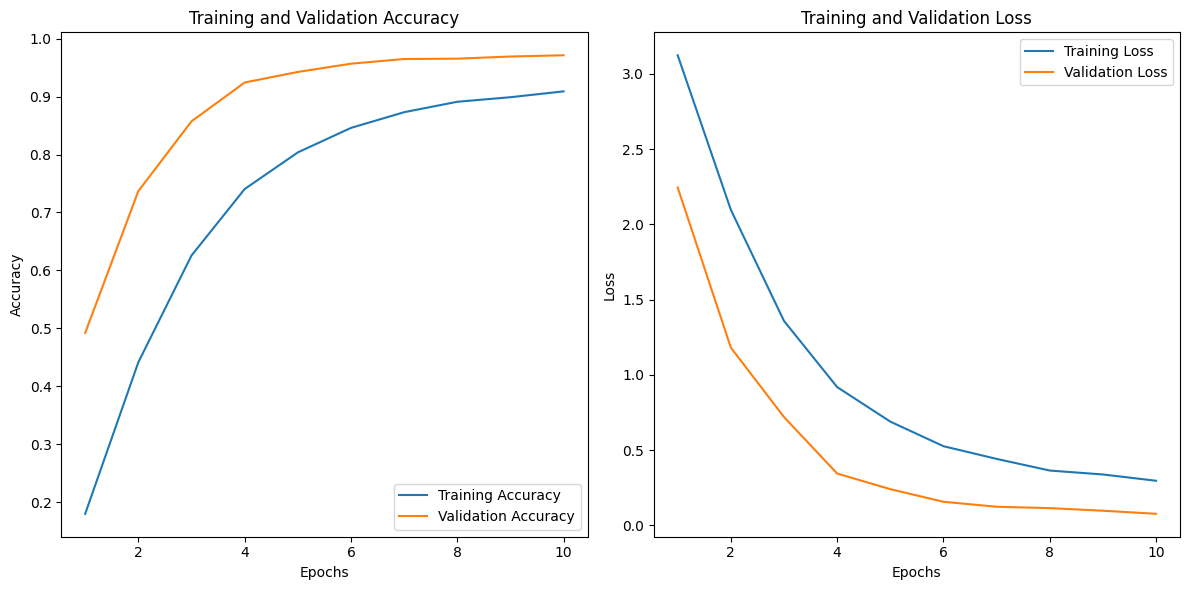

320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step
Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       1.00      1.00      1.00       348
        aluminum_food_cans       0.82      0.85      0.83       336
        aluminum_soda_cans       0.97      0.99      0.98       341
           cardboard_boxes       0.81      0.91      0.85       352
       cardboard_packaging       0.90      0.77      0.83       333
                  clothing       0.99      1.00      1.00       330
            coffee_grounds       1.00      1.00      1.00       351
disposable_plastic_cutlery       1.00      0.99      0.99       340
                 eggshells       1.00      1.00      1.00       355
                food_waste       1.00      1.00      1.00       340
    glass_beverage_bottles       0.99      1.00      0.99       328
 glass_cosmetic_containers       0.99      0.99      0.99       323
           glass_food_jars       1.00      0.99 

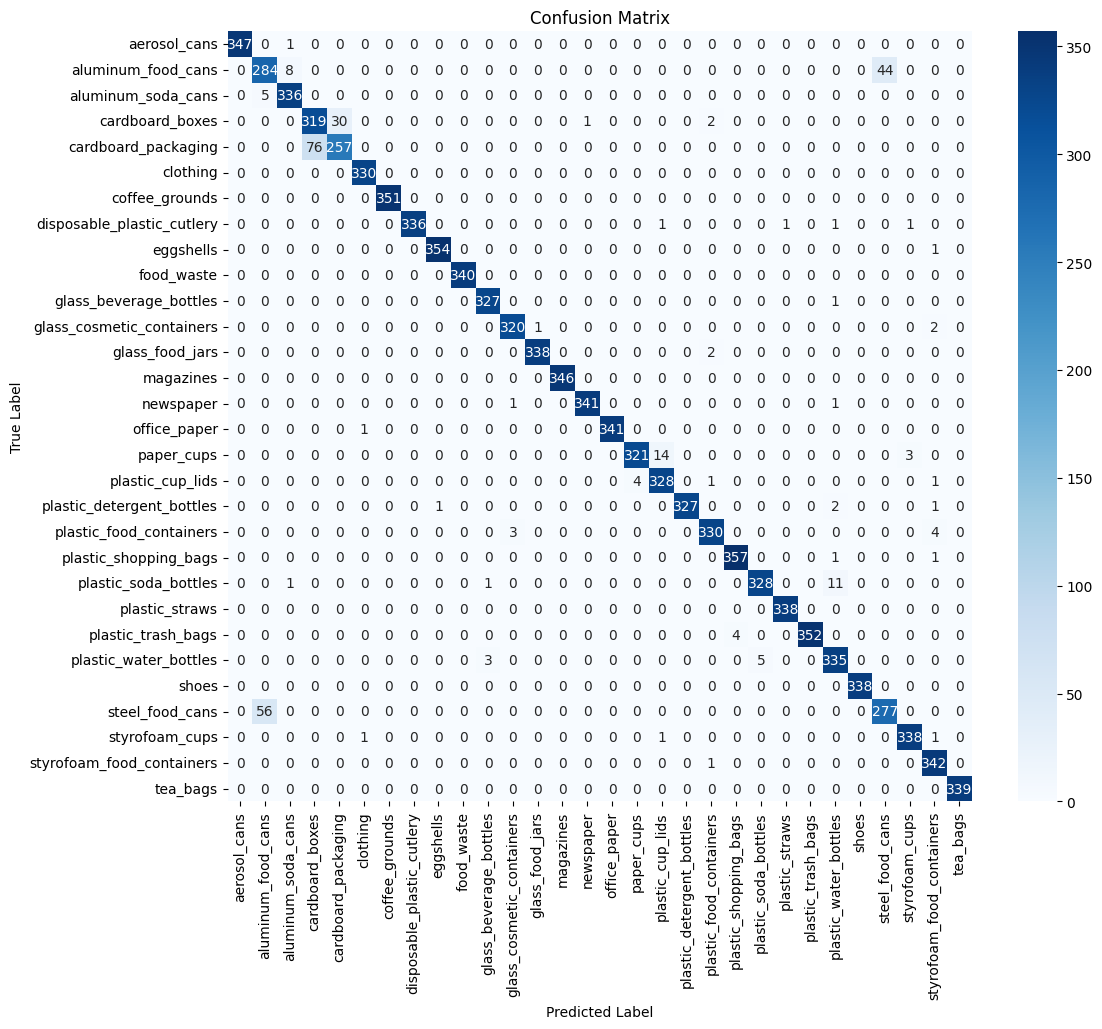

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(cnn_history)

predictions = cnn_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


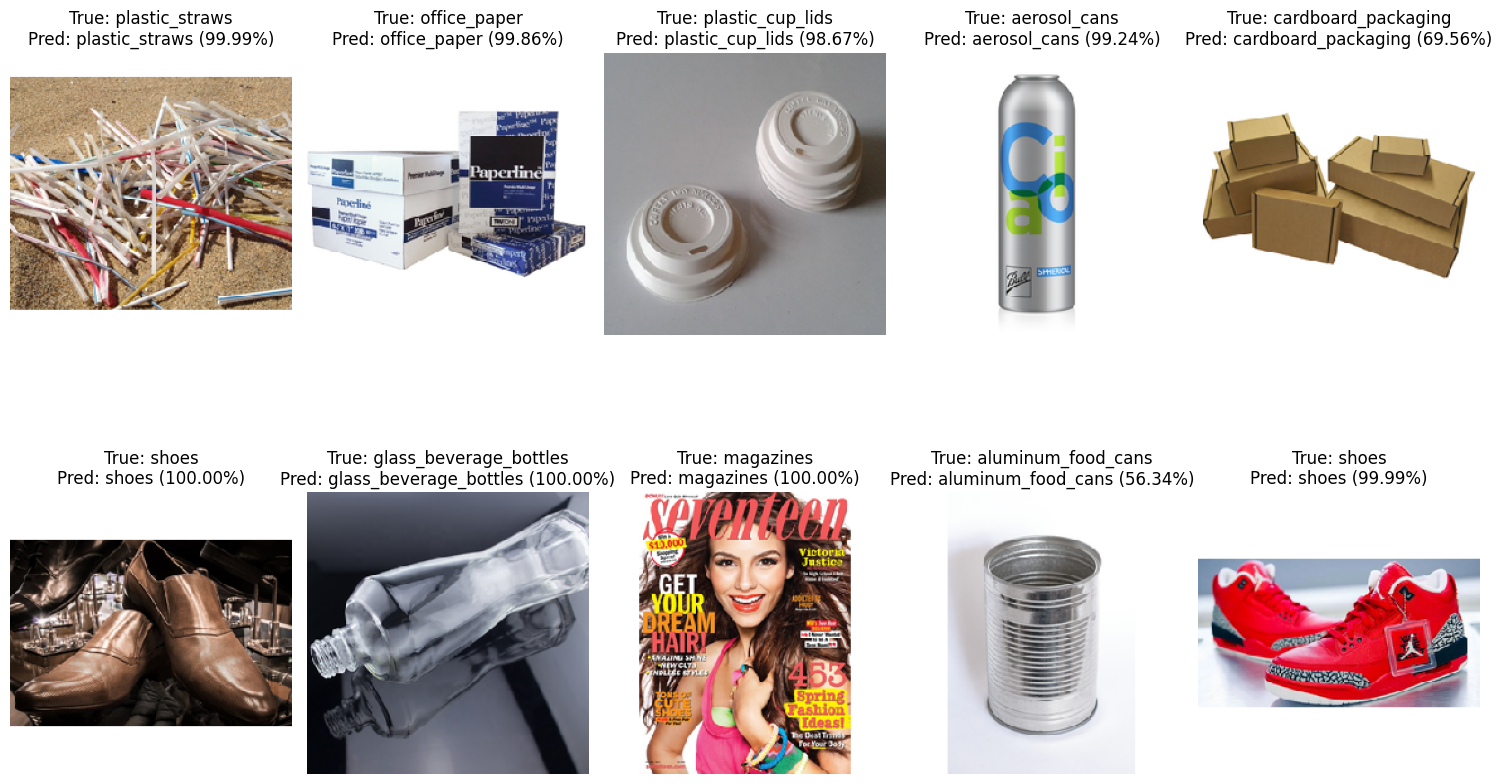

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path ke folder test
test_images_path = test_path  # Sesuaikan jika path berbeda

# Pilih 10 gambar secara acak
def get_random_images(folder_path, num_images=10):
    image_paths = []
    class_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            images = [os.path.join(class_folder, img) for img in os.listdir(class_folder)]
            image_paths.extend(images)
            class_labels.extend([class_name] * len(images))

    selected_indices = random.sample(range(len(image_paths)), num_images)
    selected_images = [image_paths[i] for i in selected_indices]
    selected_labels = [class_labels[i] for i in selected_indices]
    return selected_images, selected_labels

# Load dan preprocess gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran
    img_array = img_to_array(img) / 255.0
    return img_array

# Dapatkan gambar acak
test_images, true_labels = get_random_images(test_images_path, 10)

# Preprocess gambar
test_images_array = np.array([preprocess_image(img) for img in test_images])

# Lakukan prediksi
predictions = cnn_model.predict(test_images_array)
predicted_labels = [
    list(train_data.class_indices.keys())[np.argmax(pred)] for pred in predictions
]

# Plot hasil
def plot_predictions(images, true_labels, predicted_labels, predictions):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        img = load_img(images[i], target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
        true_label = true_labels[i]
        pred_label = predicted_labels[i]
        pred_percent = np.max(predictions[i]) * 100

        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_percent:.2f}%)")

    plt.tight_layout()
    plt.show()

plot_predictions(test_images, true_labels, predicted_labels, predictions)

# **ResNet50**

In [ ]:
base_path = "data/images/images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_data = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 13614 images belonging to 30 classes.
Found 4147 images belonging to 30 classes.
Found 4151 images belonging to 30 classes.


In [ ]:
# 2. ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

print("Training ResNet50 model...")
resnet_history = resnet_model.fit(train_data, validation_data=val_data, epochs=20)

resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_data)
print(f"ResNet50 Test Accuracy: {resnet_test_acc:.2f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet50 model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


426/426 ━━━━━━━━━━━━━━━━━━━━ 227s 385ms/step - accuracy: 0.1469 - loss: 3.1460 - val_accuracy: 0.0364 - val_loss: 4.0146
Epoch 2/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 138s 312ms/step - accuracy: 0.3443 - loss: 2.2723 - val_accuracy: 0.3311 - val_loss: 2.4067
Epoch 3/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 142s 331ms/step - accuracy: 0.4457 - loss: 1.9056 - val_accuracy: 0.0998 - val_loss: 10.7354
Epoch 4/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 135s 315ms/step - accuracy: 0.5303 - loss: 1.5803 - val_accuracy: 0.2392 - val_loss: 5.6566
Epoch 5/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 135s 316ms/step - accuracy: 0.6571 - loss: 1.1342 - val_accuracy: 0.5158 - val_loss: 1.6975
Epoch 6/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.7228 - loss: 0.8952 - val_accuracy: 0.6036 - val_loss: 1.3561
Epoch 7/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 142s 332ms/step - accuracy: 0.7523 - loss: 0.7632 - val_accuracy: 0.2226 - val_loss: 9.5306
Epoch 8/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 136s 318ms/step - accuracy: 0.7924 - loss: 0.6

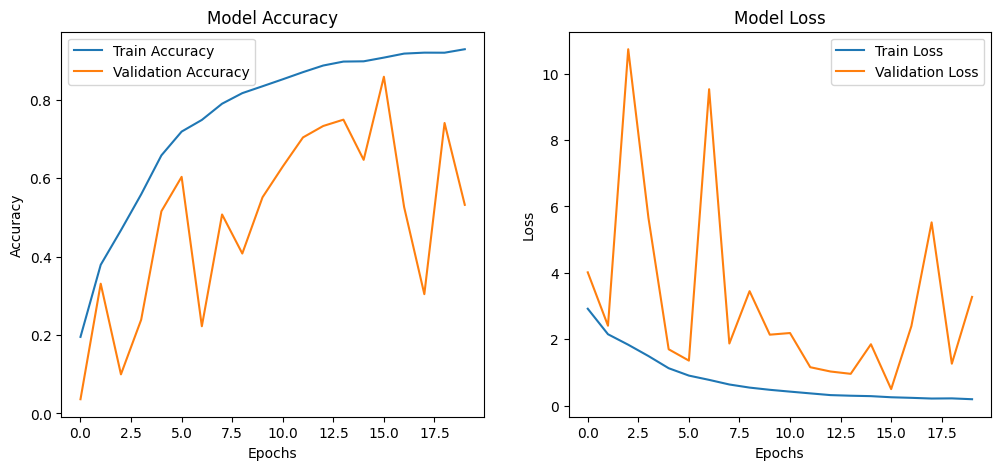

Generating classification report...
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.83      0.59      0.69       143
        aluminum_food_cans       0.73      0.29      0.42       137
        aluminum_soda_cans       0.91      0.62      0.74       139
           cardboard_boxes       0.57      0.68      0.62       137
       cardboard_packaging       0.95      0.14      0.25       141
                  clothing       0.60      0.79      0.69       140
            coffee_grounds       0.97      0.80      0.88       138
disposable_plastic_cutlery       0.74      0.70      0.72       140
                 eggshells       0.97      0.65      0.78       139
                food_waste       0.97      0.78      0.87       142
    glass_beverage_bottles       0.91      0.29      0.44       135
 glass_cosmetic_containers       0.73      0.21      0.33       143
           

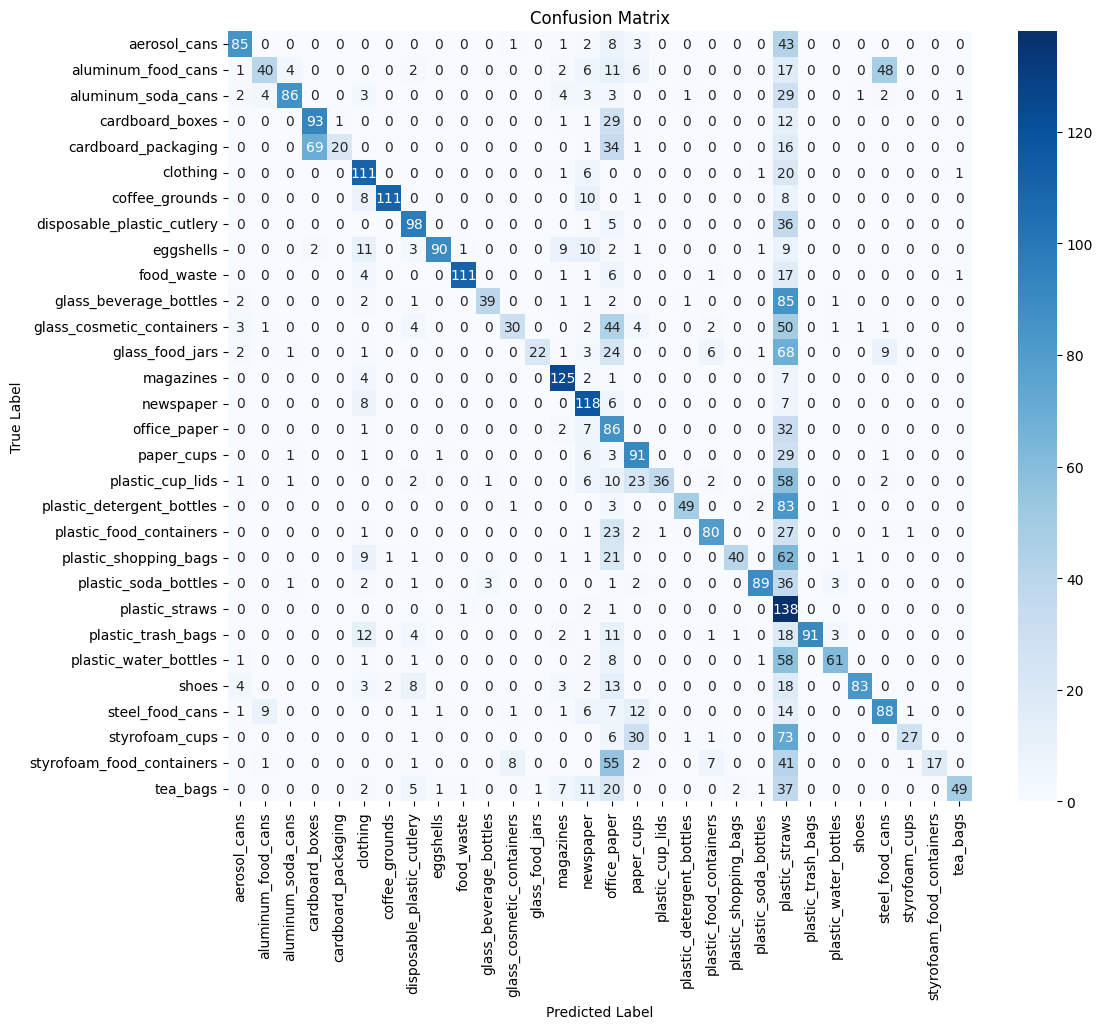

In [ ]:
# Plot Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(resnet_history)

print("Generating classification report...")
test_data.reset()
y_pred = np.argmax(resnet_model.predict(test_data), axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


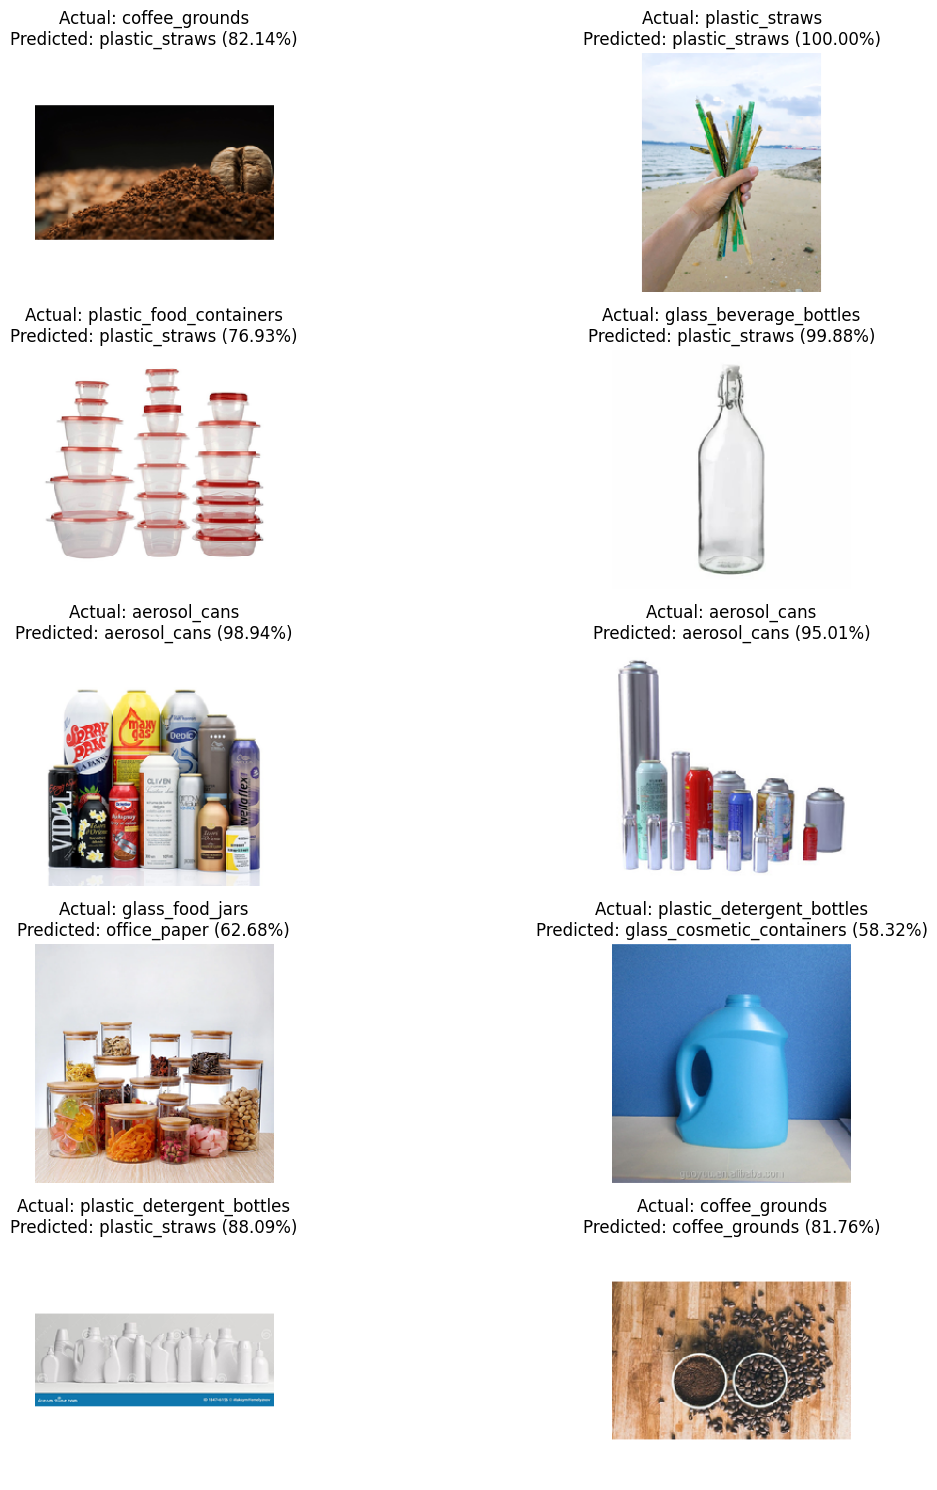

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk memuat dan memproses gambar
def load_and_process_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)  # Muat gambar dan ubah ukurannya
    img_array = img_to_array(img)  # Konversi ke array numpy
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    return img, img_array

# Ambil 10 gambar secara acak dari data test
test_image_paths = []
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        test_image_paths.extend([os.path.join(class_folder, img) for img in images])

# Pilih 10 gambar secara acak
random_images = random.sample(test_image_paths, 10)

# Lakukan prediksi dan tampilkan hasilnya
plt.figure(figsize=(15, 15))
for i, img_path in enumerate(random_images):
    # Muat dan proses gambar
    original_img, processed_img = load_and_process_image(img_path)

    # Lakukan prediksi
    prediction = resnet_model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    predicted_percentage = prediction[0][predicted_class] * 100

    # Dapatkan label sebenarnya
    actual_class = os.path.basename(os.path.dirname(img_path))
    predicted_label = list(train_data.class_indices.keys())[predicted_class]

    # Tampilkan gambar beserta labelnya
    plt.subplot(5, 2, i + 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label} ({predicted_percentage:.2f}%)")

plt.tight_layout()
plt.show()

# **VGG16**

In [ ]:
base_path = "data/images/images"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_data = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 14997 images belonging to 30 classes.
Found 10175 images belonging to 30 classes.
Found 10219 images belonging to 30 classes.


In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

vgg_model = Sequential([
    vgg_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

vgg_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training VGG16 model...")
vgg_history = vgg_model.fit(train_data, validation_data=val_data, epochs=15)

vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_data)
print(f"VGG16 Test Accuracy: {vgg_test_acc:.2f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training VGG16 model...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 152s 292ms/step - accuracy: 0.2129 - loss: 2.8732 - val_accuracy: 0.5599 - val_loss: 1.6436
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 220ms/step - accuracy: 0.4988 - loss: 1.7244 - val_accuracy: 0.6358 - val_loss: 1.3113
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 221ms/step - accuracy: 0.5674 - loss: 1.4446 - val_accuracy: 0.6711 - val_loss: 1.1312
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 220ms/step - accuracy: 0.6027 - loss: 1.3060 - val_accuracy: 0.7004 - val_loss: 1.0409
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 221ms/step - accuracy: 0.6377 - loss: 1.2128 - val_accuracy: 0.7148 - val_loss: 0.9679
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - accuracy: 0.6612 - loss: 1.1312 - val_accuracy: 0.7277 - val_loss: 0.8959
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 220ms/step - accuracy: 0.6646 - loss: 1.0782 - val_accuracy: 0.7440 - val_loss: 0.8485
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - accuracy: 0.6817 - loss: 1.02

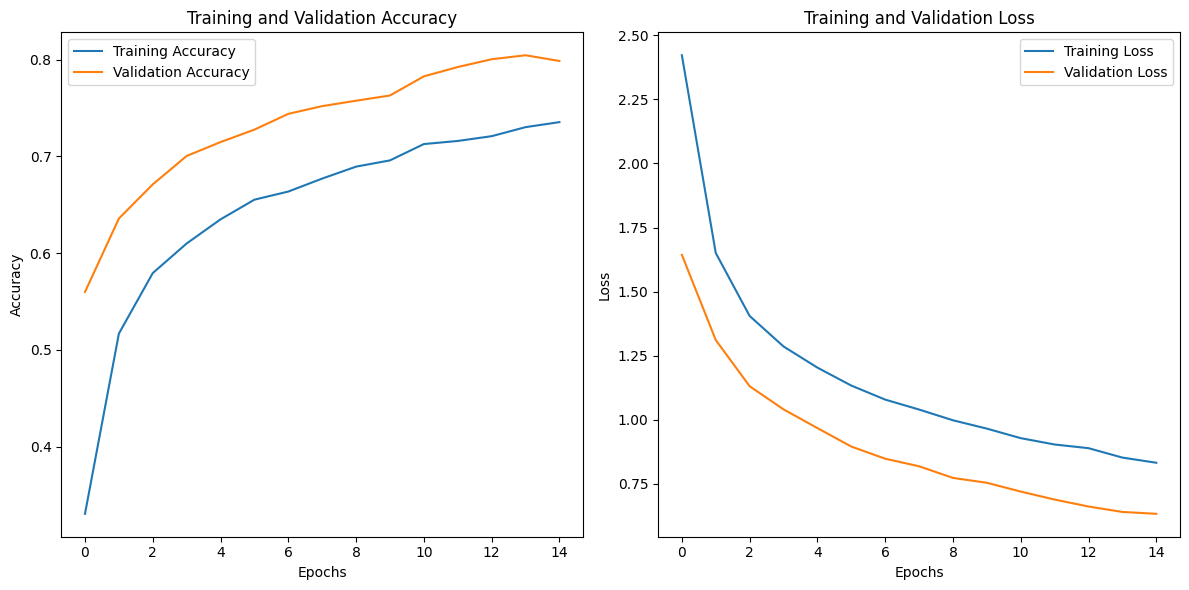

320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step
Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.90      0.84      0.87       348
        aluminum_food_cans       0.48      0.80      0.60       336
        aluminum_soda_cans       0.69      0.87      0.77       341
           cardboard_boxes       0.66      0.70      0.67       352
       cardboard_packaging       0.66      0.56      0.61       333
                  clothing       0.84      0.83      0.83       330
            coffee_grounds       0.89      0.91      0.90       351
disposable_plastic_cutlery       0.93      0.91      0.92       340
                 eggshells       0.87      0.90      0.88       355
                food_waste       0.73      0.94      0.82       340
    glass_beverage_bottles       0.89      0.79      0.84       328
 glass_cosmetic_containers       0.88      0.74      0.81       323
           glass_food_jars       0.87      0.87 

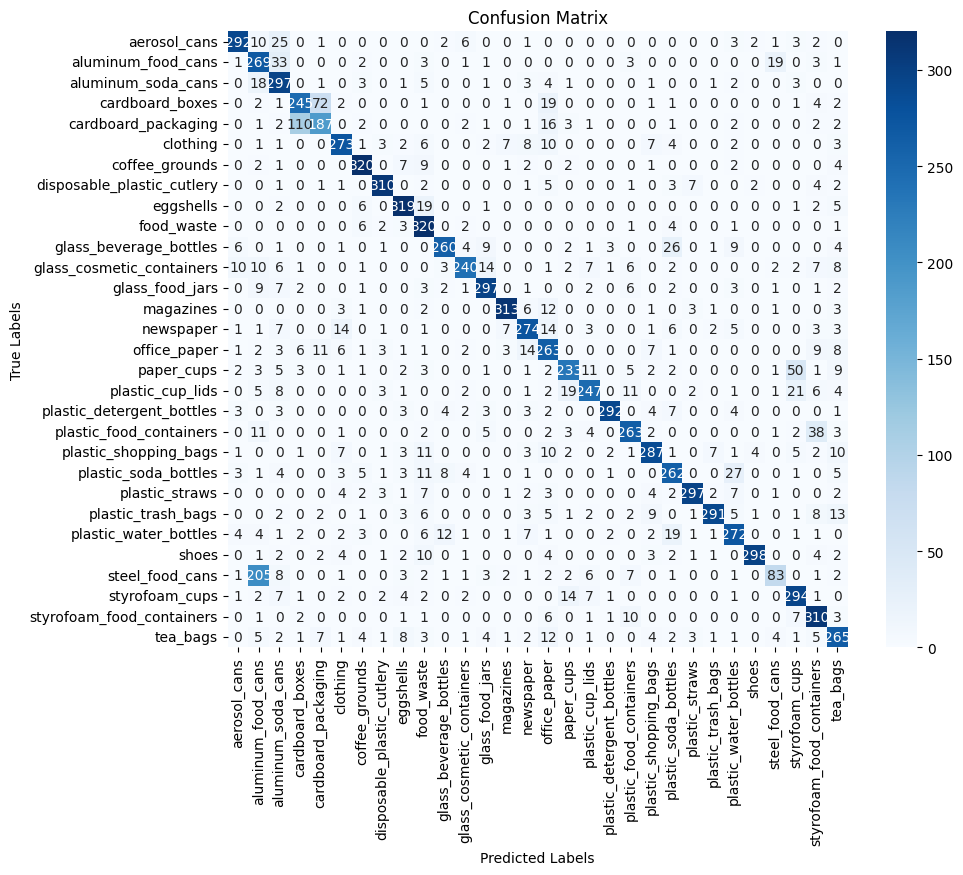

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_data.reset()
y_pred = vgg_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


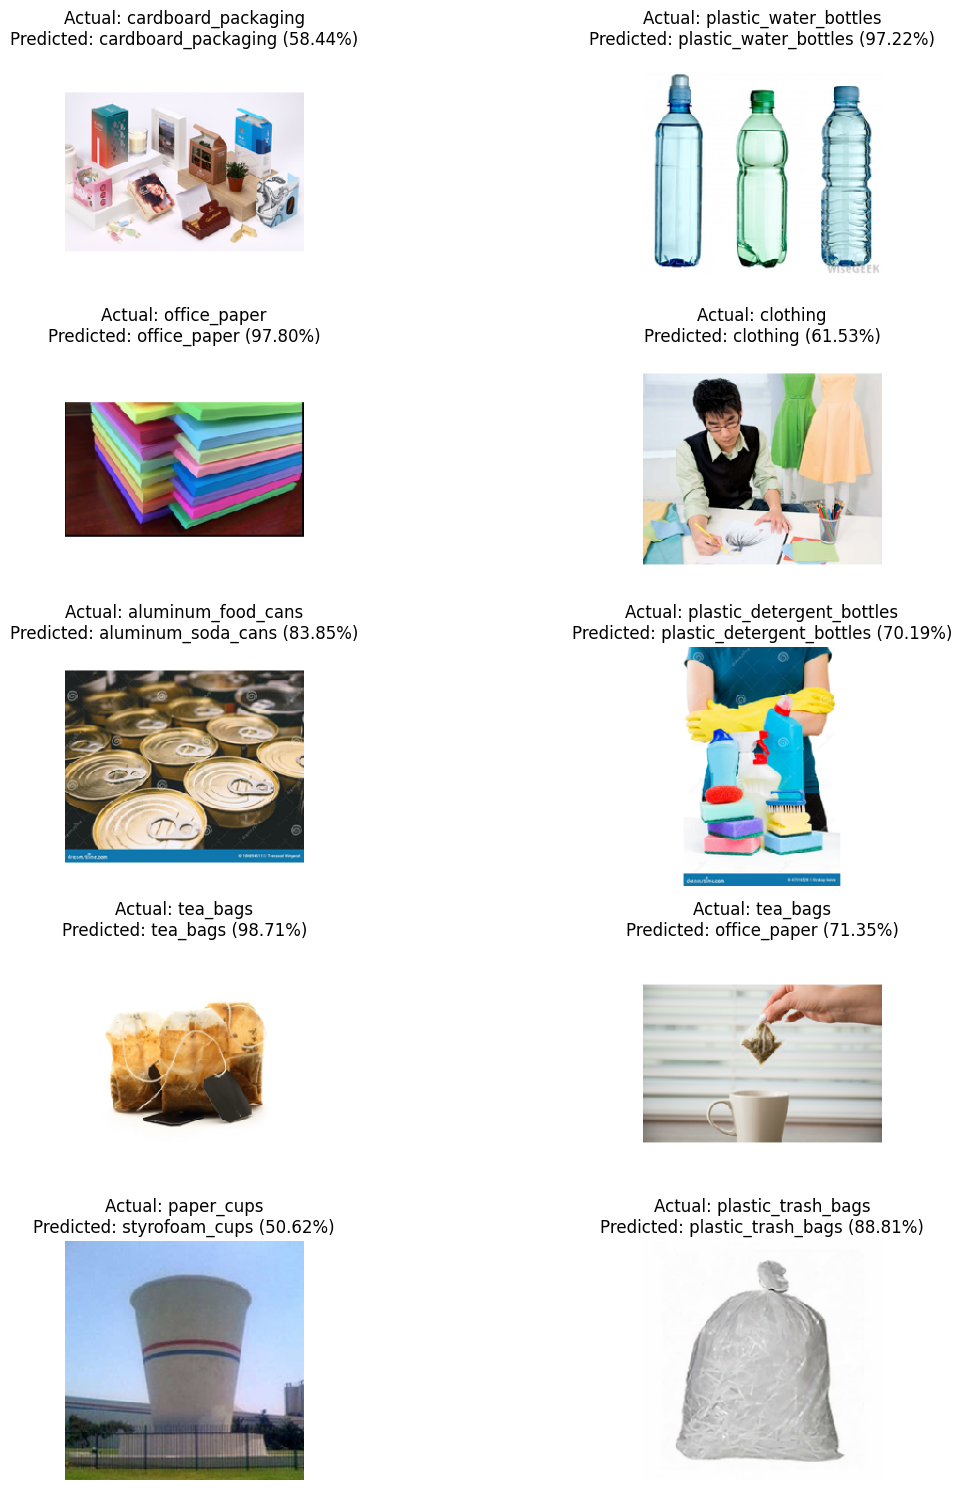

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk memuat dan memproses gambar
def load_and_process_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)  # Muat gambar dan ubah ukurannya
    img_array = img_to_array(img)  # Konversi ke array numpy
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    return img, img_array

# Ambil 10 gambar secara acak dari data test
test_image_paths = []
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        test_image_paths.extend([os.path.join(class_folder, img) for img in images])

# Pilih 10 gambar secara acak
random_images = random.sample(test_image_paths, 10)

# Lakukan prediksi dan tampilkan hasilnya
plt.figure(figsize=(15, 15))
for i, img_path in enumerate(random_images):
    # Muat dan proses gambar
    original_img, processed_img = load_and_process_image(img_path)

    # Lakukan prediksi
    prediction = vgg_model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    predicted_percentage = prediction[0][predicted_class] * 100

    # Dapatkan label sebenarnya
    actual_class = os.path.basename(os.path.dirname(img_path))
    predicted_label = list(train_data.class_indices.keys())[predicted_class]

    # Tampilkan gambar beserta labelnya
    plt.subplot(5, 2, i + 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label} ({predicted_percentage:.2f}%)")

plt.tight_layout()
plt.show()

# **Model H5**


In [ ]:
# prompt: buatkan model h5 untuk CNN dan download

cnn_model.save('cnn_model.h5')
from google.colab import files
files.download('cnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: buatkan model h5 untuk ResNet50 dan download

resnet_model.save('resnet_model.h5')
files.download('resnet_model.h5')

In [ ]:
# prompt: buatkan model h5 untuk VGG dan download

vgg_model.save('vgg_model.h5')
files.download('vgg_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>